In [1]:
import pandas as pd
import pyranges as pr
import sys
import os
from Bio import SearchIO

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
def read_pred():
    df = pd.read_csv('human_cds.bed', sep='\t',
                     header=None, usecols=[0,1,2,3,5,6,7])
    df.columns = ['Chromosome', 'Start', 'Stop', 'fields', 'Strand',
                  'CDS_Start', 'CDS_Stop']
    # df['tid'] = df.fields.str.split(';', expand=True)[1]
    df[['gid', 'tid', 'gname', '.',
        'pid', 't_len_flag', 'blastp_match',
        'nmd_flag', 'frame']] \
        = df.fields.str.split(';', expand=True)
    df.drop('.', axis=1, inplace=True)
    # print(df.fields.str.split(';', expand=True))

    # get rid of sirvs and erccs
    df = df.loc[~df.Chromosome.str.contains('ERCC')]
    df = df.loc[~df.Chromosome.str.contains('SIRV')]

    # check if transcript is novel 
    df['novel_transcript'] = df.tid.str.contains('ENCODE')

    # check if transcript is nmd
    df['nmd'] = ~(df.nmd_flag == 'prot_ok')

    # check if transcript is full length 
    df['full_orf'] = df.t_len_flag == 'full_length'
    
    # typing
    df.loc[df.blastp_match == 'no_orf', 'blastp_match'] = 0
    df['blastp_match'] = df.blastp_match.astype(float)
    
    return df

In [7]:
df = read_pred()

In [17]:
# limit to novel transcripts
df = df.loc[df.novel_transcript == True]

In [54]:
n_nov = len(df.tid.unique())
print('Found {} unique novel transcripts'.format(n_nov))

Found 36206 unique novel transcripts


## How many novel isoforms are predicted to be protein coding?
Based on whether:
* novel isoform is predicted to be subject to NMD
* novel isoform has a full length predicted ORF

In [58]:
temp = df.loc[~df.nmd&df.full_orf]
n = len(temp.index)
print('{} / {} ({:.2f}%) novel isoforms are predicted to be protein coding'.format(n, n_nov, ((n/n_nov)*100)))

17315 / 36206 (47.82%) novel isoforms are predicted to be protein coding


## How many novel isoforms are predicted to have NMD?

In [59]:
temp = df.loc[df.nmd]
n = len(temp.index)
print('{} / {} ({:.2f}%) novel isoforms are predicted to be subject to NMD'.format(n, n_nov, ((n/n_nov)*100)))

11350 / 36206 (31.35%) novel isoforms are predicted to be subject to NMD


In [56]:
len(df.tid.unique().tolist())

36206

  transcript_novelty  counts
0          Antisense   11385
1                ISM   49118
2         Intergenic    1059
3              Known   96699
4                NIC   27407
5                NNC    8835
Number of complete isoforms: 132941


<Figure size 288x432 with 0 Axes>

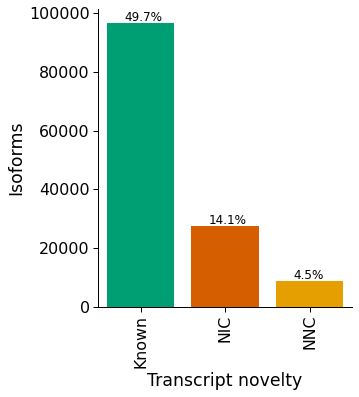

36242

<Figure size 432x288 with 0 Axes>

In [34]:
t_df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty(t_df,
                        oprefix='figures/complete_no_tpm_req',
                       novs=['Known', 'NIC', 'NNC'])
27407+8835

In [43]:
# so which transcripts are missing in the tama output and why? 
novs = ['NIC', 'NNC']
ctrl_tids = t_df.loc[t_df.transcript_novelty.isin(novs), 'annot_transcript_id'].unique().tolist()
test_tids = df.tid.unique().tolist()

In [51]:
missing_tids = list(set(ctrl_tids)-set(test_tids))[:5]
missing_tids[:5]

['ENCODEHT000206965',
 'ENCODEHT000206911',
 'ENCODEHT000206977',
 'ENCODEHT000212834',
 'ENCODEHT000206785']

In [53]:
t_df.loc[t_df.annot_transcript_id.isin(missing_tids)].groupby('gene_novelty').count()

,gene_ID,transcript_ID,annot_gene_id,annot_transcript_id,annot_gene_name,annot_transcript_name,n_exons,length,transcript_novelty,ISM_subtype,...,calu3_1_2,brodmann_area_46_1_1,brodmann_area_46_7_1,brodmann_area_46_5_1,brodmann_area_46_6_1,brodmann_area_46_8_1,brodmann_area_46_4_1,brodmann_area_46_2_1,brodmann_area_46_9_1,brodmann_area_46_3_1
gene_novelty,,,,,,,,,,,,,,,,,,,,,
Antisense,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Intergenic,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


So all the missing transcripts are from antisense or intergenic novel genes; we're good

## What NMD status is each isoform?

In [11]:
df = read_pred()

In [9]:
df.head()

,Chromosome,Start,Stop,fields,Strand,CDS_Start,CDS_Stop,gid,tid,gname,pid,t_len_flag,blastp_match,nmd_flag,frame,novel_transcript,nmd,full_orf
0,chr1,14403,29570,ENSG00000227232.5;ENCODEHT000207057;NA;NA;none...,-,17327,17687,ENSG00000227232.5,ENCODEHT000207057,NA,none,full_length,0,NMD5,F1,True,True,True
1,chr1,14403,29570,ENSG00000227232.5;ENCODEHT000207076;NA;NA;ENSP...,-,17735,24886,ENSG00000227232.5,ENCODEHT000207076,NA,ENSP00000494459.1,full_length,100.00,NMD6,F1,True,True,True
2,chr1,14403,29570,ENSG00000227232.5;ENCODEHT001150534;NA;NA;ENSP...,-,17735,24886,ENSG00000227232.5,ENCODEHT001150534,NA,ENSP00000494459.1,full_length,100.00,NMD5,F1,True,True,True
3,chr1,14408,29570,ENSG00000227232.5;ENCODEHT000207067;NA;NA;none...,-,16747,17310,ENSG00000227232.5,ENCODEHT000207067,NA,none,full_length,0,NMD3,F3,True,True,True
4,chr1,17368,17436,ENSG00000278267.1;ENST00000619216.1;NA;NA;none...,-,17371,17434,ENSG00000278267.1,ENST00000619216.1,NA,none,5prime_degrade,0,prot_ok,F3,False,False,False


In [10]:
df = df[['tid', 'nmd_flag']]
df.to_csv('nmd_status.tsv', sep='\t', index=False)

## What % of novel complete protein predictions have 100% blastp homology?

In [25]:
df = read_pred()
df = df.loc[df.novel_transcript == True]
n_nov = len(df.loc[(~df.nmd)&(df.full_orf)].index)
n = len(df.loc[(~df.nmd)&(df.full_orf)&(df.blastp_match == 100)])
print('{} / {} ({:.2f}%) of predicted FL CDS isoforms have 100% blastp homology'.format(n, n_nov, ((n/n_nov)*100)))

14464 / 17315 (83.53%) of predicted FL CDS isoforms have 100% blastp homology


In [19]:
df.dtypes

Chromosome           object
Start                 int64
Stop                  int64
fields               object
Strand               object
CDS_Start             int64
CDS_Stop              int64
gid                  object
tid                  object
gname                object
pid                  object
t_len_flag           object
blastp_match        float64
nmd_flag             object
frame                object
novel_transcript       bool
nmd                    bool
full_orf               bool
dtype: object

In [22]:
df.loc[(df.blastp_match==100)&(~df.nmd)]

,Chromosome,Start,Stop,fields,Strand,CDS_Start,CDS_Stop,gid,tid,gname,pid,t_len_flag,blastp_match,nmd_flag,frame,novel_transcript,nmd,full_orf
33,chr1,632756,633438,ENSG00000229344.1;ENST00000427426.1;NA;NA;ENSP...,+,632756,632948,ENSG00000229344.1,ENST00000427426.1,NA,ENSP00000354876.1,5prime_degrade,100.0,prot_ok,F1,False,False,False
56,chr1,923927,944259,ENSG00000187634.11;ENCODEHT001155508;NA;NA;ENS...,+,924431,944150,ENSG00000187634.11,ENCODEHT001155508,NA,ENSP00000482090.1,full_length,100.0,prot_ok,F1,True,False,True
57,chr1,923927,944575,ENSG00000187634.11;ENCODEHT001155519;NA;NA;ENS...,+,924431,944150,ENSG00000187634.11,ENCODEHT001155519,NA,ENSP00000482090.1,full_length,100.0,prot_ok,F1,True,False,True
58,chr1,925737,944575,ENSG00000187634.11;ENST00000342066.7;NA;NA;ENS...,+,925739,944150,ENSG00000187634.11,ENST00000342066.7,NA,ENSP00000482090.1,5prime_degrade,100.0,prot_ok,F3,False,False,False
59,chr1,925740,944581,ENSG00000187634.11;ENST00000622503.4;NA;NA;ENS...,+,925742,944150,ENSG00000187634.11,ENST00000622503.4,NA,ENSP00000482090.1,5prime_degrade,100.0,prot_ok,F3,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132495,chr22_KI270734v1_random,138081,161626,ENSG00000277196.4;ENCODEHT000208010;NA;NA;ENSP...,-,138482,161626,ENSG00000277196.4,ENCODEHT000208010,NA,ENSP00000474199.1,5prime_degrade,100.0,prot_ok,F1,True,False,False
132496,chr22_KI270734v1_random,138081,161626,ENSG00000277196.4;ENCODEHT000208041;NA;NA;ENSP...,-,138482,150383,ENSG00000277196.4,ENCODEHT000208041,NA,ENSP00000474199.1,full_length,100.0,prot_ok,F3,True,False,True
132497,chr22_KI270734v1_random,138081,161626,ENSG00000277196.4;ENCODEHT000208122;NA;NA;ENSP...,-,138482,150995,ENSG00000277196.4,ENCODEHT000208122,NA,ENSP00000474199.1,full_length,100.0,prot_ok,F3,True,False,True
132498,chr22_KI270734v1_random,138081,161750,ENSG00000277196.4;ENCODEHT003580941;NA;NA;ENSP...,-,138482,150383,ENSG00000277196.4,ENCODEHT003580941,NA,ENSP00000474199.1,full_length,100.0,prot_ok,F1,True,False,True


## HMMER output

In [40]:
fname = 'human_hmmer.out'
tids = []
domains = []
with open(fname, 'r') as handle:
    i = 0
    for record in SearchIO.parse(handle, 'hmmer3-text'):
        qid = record.id
        tid = qid.split(';')[1]
        hits = record.hits
        # print(tid)
        # print(qid)
        # print(hits)
        for hit in hits:
            tids.append(tid)
            domains.append(hit.id)
            # print(hit.id)
            # print(hit.description)
        i += 1
        # if i > 2:
        #     break
        

In [41]:
df = pd.DataFrame()
df['tid'] = tids
df['domain'] = domains

In [42]:
df.head()

,tid,domain
0,ENCODEHT000207057,WASH_WAHD
1,ENCODEHT000207076,WASH_WAHD
2,ENCODEHT000207076,WASH_WAHD
3,ENCODEHT001150534,WASH_WAHD
4,ENCODEHT001150534,WASH_WAHD


In [44]:
t_df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
t_df = t_df[['annot_transcript_id', 'annot_gene_id', 'annot_gene_name', 'transcript_novelty']] 
t_df.head()

,annot_transcript_id,annot_gene_id,annot_gene_name,transcript_novelty
0,ENST00000619216.1,ENSG00000278267.1,MIR6859-1,Known
1,ENST00000469289.1,ENSG00000243485.5,MIR1302-2HG,Known
2,ENST00000417324.1,ENSG00000237613.2,FAM138A,Known
3,ENST00000461467.1,ENSG00000237613.2,FAM138A,Known
4,ENST00000453576.2,ENSG00000238009.6,AL627309.1,Known


In [45]:
df = df.merge(t_df, how='left', left_on='tid', right_on='annot_transcript_id')
df.head()

,tid,domain,annot_transcript_id,annot_gene_id,annot_gene_name,transcript_novelty
0,ENCODEHT000207057,WASH_WAHD,ENCODEHT000207057,ENSG00000227232.5,WASH7P,NIC
1,ENCODEHT000207076,WASH_WAHD,ENCODEHT000207076,ENSG00000227232.5,WASH7P,NIC
2,ENCODEHT000207076,WASH_WAHD,ENCODEHT000207076,ENSG00000227232.5,WASH7P,NIC
3,ENCODEHT001150534,WASH_WAHD,ENCODEHT001150534,ENSG00000227232.5,WASH7P,NIC
4,ENCODEHT001150534,WASH_WAHD,ENCODEHT001150534,ENSG00000227232.5,WASH7P,NIC


In [46]:
df.loc[df.annot_gene_id == 'ENSG00000227232.5']

,tid,domain,annot_transcript_id,annot_gene_id,annot_gene_name,transcript_novelty
0,ENCODEHT000207057,WASH_WAHD,ENCODEHT000207057,ENSG00000227232.5,WASH7P,NIC
1,ENCODEHT000207076,WASH_WAHD,ENCODEHT000207076,ENSG00000227232.5,WASH7P,NIC
2,ENCODEHT000207076,WASH_WAHD,ENCODEHT000207076,ENSG00000227232.5,WASH7P,NIC
3,ENCODEHT001150534,WASH_WAHD,ENCODEHT001150534,ENSG00000227232.5,WASH7P,NIC
4,ENCODEHT001150534,WASH_WAHD,ENCODEHT001150534,ENSG00000227232.5,WASH7P,NIC
5,ENCODEHT000207067,WASH_WAHD,ENCODEHT000207067,ENSG00000227232.5,WASH7P,NIC


In [47]:
temp = df[['tid', 'transcript_novelty']].drop_duplicates()
temp.groupby('transcript_novelty').count()

,tid
transcript_novelty,
Known,69537
NIC,25836
NNC,7995
